# Laplace Likningen og Iterative Metoder

### FY1003 Elektrisitet og Magnetisme - Numerisk Øving 2

En av de mest sentrale likningene i elektromagnetismen er Laplace likningen, $\nabla^2 V(x,y) = 0$, som beskriver det elektriske felt i vakuum. Denne øvingen handler om å løse Laplace likningen i 2 dimensjoner ved å bruke tre *iterative* metoder, Jacobi metoden,  Gauss-Seidel metoden, og SOR (Successive Over-Relaxation), samt å sammenlikne disse tre metodene.

### Laplace likningen for boks med konstant sidekant

En av de enklere systemene vi kan se på er en kvadratisk boks med lengde, $L$, hvor potensialet på den ene siden er holdt konstant, $V = V_0$, og den motsatte siden er jordet, $V = 0$. I denne oppgaven velger vi periodiske grensebetingelser for de to gjenstående sidene, men det er også vanlig å la disse være jordet. For å finne potensialet inne i boksen må man dermed finne en løsning til Laplace likningen, $\nabla^2 V(x,y) = 0$, som oppfyller grensebetingelsene 

- $V(0,y) = V_0 = 1$,
- $V(L, y) = 0$,
- $V(x,0) = V(x,L)$.

Dette er en andreordens homogen partiell differensiallikning, og med de gitte grensebetingelsene er det garantert at det eksisterer en unik løsning inne i boksen.

Diskretisering av Laplace likningen gir 
\begin{equation}
0 = \frac{V(x_{i-1},y_j) - 2V(x_i, y_j) + V(x_{i+1},y_j)}{\Delta x} + \frac{V(x_i,y_{j-1}) - 2V(x_i, y_j) + V(x_i,y_{j+1})}{\Delta y}\text{,}
\end{equation}

hvis vi setter $\Delta x = \Delta y$ får vi
\begin{equation}
V(x_i, y_j) = \frac{1}{4}\big[ V(x_{i-1},y_j) + V(x_{i+1},y_j) + V(x_i,y_{j-1}) + V(x_i,y_{j+1})\big] \text{,}
\end{equation}
som gir oss utgangspunktet for de iterative metodene.

I dette enkle tilfellet er den analytiske løsningen kjent, nemlig $V(x,y) = 1-x/L$ 

### Oppgave 1: Analytisk løsning

Plot den analytiske løsningen $V(x,y) = 1-x/L$ for $x,y \in [0,1]$. Dette kan for eksempel løses ved hjelp av np.meshgrid og plt.imshow som i øving 1.

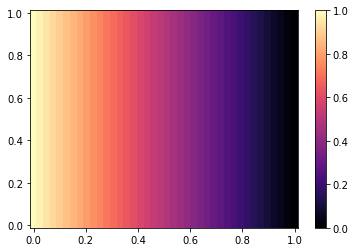

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
#-----------------SKRIV DIN LØSNING HER--------------------------------------------------------------#
N = 40
x = y = np.linspace(0, 1, N)

xx, yy = np.meshgrid(x,y)

L = 1

V_analytic = 1 - xx/L

plt.pcolormesh(xx,yy,V_analytic, cmap='magma',shading='auto')
plt.colorbar()
plt.show()

### Oppgave 2: Jacobi metoden

Jacobi metoden er en iterativ metode for å løse et system med lineære ligninger. Ideén er at man gjetter en prøveløsning $V^{(0)}$ og bruker denne til å generere en ny løsning $V^{(1)}$ ved hjelp av en rekursjonsformel, der den nye løsningen (forhåpentligvis) er nærmere riktig løsning enn den vi startet med. Man kan så gjennta denne prosessen for den nye løsningen og generere en følge med løsninger $\{V^{(k)}\}$ som konvergerer gradvis mot riktig løsning når $k$ øker.

For Laplace likningen vil Jacobi-metoden gi følgende rekursjonsformel:
\begin{equation}
V^{(\text{k}+1)}(x_i, y_j)= \frac{1}{4}\big[ V^{(\text{k})}(x_{i-1},y_j) + V^{(\text{k})}(x_{i+1},y_j) + V^{(\text{k})}(x_i,y_{j-1}) + V^{(\text{k})}(x_i,y_{j+1})\big]\text{.}
\end{equation}
Dere skal nå bruke rekursjonsformelen til å løse Laplace ligning rekursivt. 

$\textbf{2a)}$ Skriv en funksjon <i> Jacobi_step </i> som tar inn en $N\times N$ matrise $V^{(k)}$ samt størrelsen $N$ og returnerer matrisen $V^{(k+1)}$. Denne funksjonen skal altså gå gjennom alle $x_i$ og $y_j$ (representert ved indexer i matrisen $V^{(k)}$) og regne ut $V^{(k+1)}(x_i, y_j)$ gitt ved formelen over. Ting å være obs på:
<ul>
<li> Det er periodiske grensebetingelser langs y-retningen, som vil si at $V^{(k)}(x_i, y_N) = V^{(k)}(x_i, y_0)$ (For 0-indeksering som i python)</li>
<li> Potensialet holdes konstant langs de to kantene $V^{(k)}(x_0, y_j)$ og $V^{(k)}(x_{N-1}, y_j)$, så disse skal ikke oppdateres </li> ift rekursjonsformelen men settes til riktige verdier.
<li> $x$-verdiene svarer til kolonner og $y$-verdiene til rader i matrisen, slik at indexene blir omvendt av det vi er vant til med kartesiske kordinater</li>
</ul>

In [80]:
#-----------------SKRIV DIN LØSNING HER--------------------------------------------------------------#
def Jacobi_step(V_k, N):
    V = np.copy(V_k)
    for i in range(1,N-1):
        for j in range(1,N-1):
            V_new = 1/4 * (V[i-1,j]+V[i+1,j]+V[i,j-1]+V[i,j+1])
            V_k[i,j] = V_new
            V_k[0,j] = V_k[N-1,j] = V_k[i,j]
    return V_k

Nå som vi har en metode for å regne ut $V^{(k+1)}$ trenger vi en metode for å bestemme når løsningen vår er 'god nok'. Siden vi vet den analytiske løsningen $V$ kan vi sammenligne med denne ved hjelp av matrise-normen, $||V^{(k)} - V||$, som går mot null når den itterative løsningen konvergerer mot den analytiske løsningen. Vi kan derfor velge en numerisk toleranse "<i>tol</i>", og si at den itterative løsningen er god nok når $||V^{(k)} - V|| < tol$.

$\mathbf{2b)}$ Skriv en funksjon <i>Jacobi</i> som tar inn en prøveløsning $V^{(0)}$, den analytiske løsningen $V$ (begge $N \times N$ matriser), størrelsen $N$ og den numeriske toleransen $tol$. Denne funksjonen skal så iterere over løsninger ved hjelp av funksjonen <i>Jacobi_step</i> frem til kravet $||V^{(k)} - V|| < tol$ er tilfredstilt. <i>Jacobi</i> skal til slutt returnere den iterative løsningen $V^{(k)}$, antall itterasjoner som ble gjort for å finne denne, samt tiden det tok. Tips:
<ul>
    <li> Matrise-normen kan regnes ut ved funksjonen <i>np.linalg.norm</i>. </li>
    <li> Funksjonen <i>time.time()</i> returnerer tidspunkt, så denne kan brukes på starten og slutten av funksjonen for å regne ut tiden som brukes. </li>

In [81]:
#-----------------SKRIV DIN LØSNING HER--------------------------------------------------------------#
tol = 0.1
V_0 = np.zeros((N,N))
for i in range(N):
    V_0[i,0] = 1
    
def Jacobi(V_0, V, N, tol):
    start = time.time()
    i = 0
    V_k = Jacobi_step(V_0, N)
    diff = tol+1
    while diff > tol:
        V_k = Jacobi_step(V_k, N)
        diff = np.linalg.norm(V_k-V)
        i += 1
    stop = time.time()
    return V_k, i, stop-start

Bruk funskjonen <i>Jacobi</i> til å finne en iterativ løsning på Laplace ligning for $N=40$, $tol = 10^{-1}$. Plott resultatet og skriv ut tiden funksjonen bruker samt antall steg. 
<ul>
    <li> Et eksempel på en prøveløsning er en matrise der alle elementene er 0 uten om de i den venstre kolonnen, som er 1 (i henhold til grensebetingelsene). Her går det sikkert ann å prøve seg frem litt. </li>
</ul>

Programmet kjørte 3192 iterasjoner og brukte 5.41417 sekunder


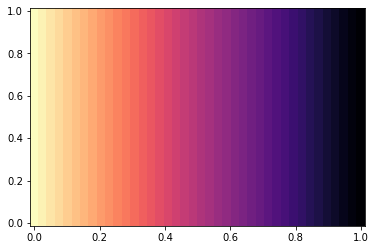

In [82]:
V_k, i, tid = Jacobi(V_0,V_analytic, N, 0.1)
plt.pcolormesh(xx,yy,V_k, cmap='magma', shading='auto')
print('Programmet kjørte' ,i, 'iterasjoner og brukte',round(tid,5), 'sekunder')

### Oppgave 3: Gauss-Seidel metoden

Gauss-seidel metoden er veldig lik Jacobi metoden, men som regel et bedre valg ettersom den bruker mindre minne
og som regel vil konvergere raskere. Forskjellen er at Gauss-Seidel kun bruker én matrise for $V^{(k)}$, ved at den bruker de oppdaterte verdiene for $V^{(k+1)}$ etterhvert som de blir beregnet i samme itterasjon over matrisen. Dermed blir rekursjonsformelen:
\begin{equation}
V(x_i, y_j)= \frac{1}{4}\big[ V(x_{i-1},y_j) + V(x_{i+1},y_j) + V(x_i,y_{j-1}) + V(x_i,y_{j+1})\big]\text{.}
\end{equation}
der vi har droppet $k$-indeksen ettersom $V^{(k+1)}$ avhenger både av seg selv og $V^{(k)}$.

$\mathrm{3a)}$ Skriv en funksjon <i>Gauss_Seidel</i> som tar inn en prøveløsning $V^{(0)}$, den analytiske løsningen $V$, $N$ og en numerisk toleranse $tol$. Denne skal så finne en iterativ løsning som tilfretstiller 
$||V^{(k)} - V|| < tol$, der $V^{(k)}$ blir regnet ut ved hjelp av Gauss-Seidel rekursjonsformelen beskrevet over.
<ul>
    <li> Her er det mulig å gjennbruke mesteparten av koden fra oppgave 2 med noen små endringer </li>
</ul>

In [83]:
%%time
#-----------------SKRIV DIN LØSNING HER--------------------------------------------------------------#
def Gauss_Seidel_step(V_k, N):
    for i in range(1,N-1):
        for j in range(1,N-1):
            V = 1/4 * (V_k[i-1,j]+V_k[i+1,j]+V_k[i,j-1]+V_k[i,j+1])
            V_k[i,j] = V
            V_k[0,j] = V_k[N-1,j] = V_k[i,j]
    return V_k

V_0 = np.zeros((N,N))
for i in range(N):
    V_0[i,0] = 1
def Gauss_Seidel(V_0, V, N, tol):    
    i = 0
    V_k = Gauss_Seidel_step(V_0, N)
    diff = tol+1
    while diff > tol:
        V_k = Gauss_Seidel_step(V_k, N)
        diff = np.linalg.norm(V_k-V, ord='fro')
        i += 1
    return V_k, i

CPU times: user 32 µs, sys: 8 µs, total: 40 µs
Wall time: 42.9 µs


$\mathrm{3b)}$ Finn en iterativ løsning for Laplace ligning ved hjelp av Gauss-Seidel metoden for de samme parameterene som i 2c. Plot resultatene og skriv ut anntal steg brukt samt tid. Sammenlign resultatene med de du fant for Jakobi metoden i oppgave 2. 

Programmet kjørte 1567 iterasjoner
CPU times: user 2.66 s, sys: 16.2 ms, total: 2.68 s
Wall time: 2.69 s


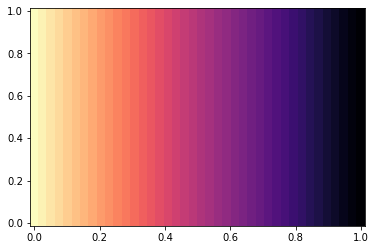

In [84]:
%%time
#-----------------SKRIV DIN LØSNING HER--------------------------------------------------------------#
V_k, i = Gauss_Seidel(V_0,V_analytic, N, 0.1)
plt.pcolormesh(xx,yy,V_k, cmap='magma', shading='auto')
print('Programmet kjørte' ,i, 'iterasjoner')

### Oppgave 4: Succesive Over-Relaxation (SOR) metoden

SOR metoden er igjen nesten identisk med Gauss-Seidel, med den forskjellen at man innfører en <i>relaxation parameter</i>, $\omega \in (0,2)$, og bruker denne til å generere en rekursjonsformel med et veid gjennomsnitt

\begin{equation}
V(x_i, y_j)= (1 - \omega)V(x_i, y_j) +  \frac{\omega}{4}\big[ V(x_{i-1},y_j) + V(x_{i+1},y_j) + V(x_i,y_{j-1}) + V(x_i,y_{j+1})\big]\text{.}
\end{equation}

Ut ifra valg av $\omega$ kan denne metoden føre til en drastisk forbedring i konvergenshastighet.

$\mathrm{4a)}$ Skriv en funksjon <i>SOR</i> som tar inn en prøveløsning $V^{(0)}$, den analytiske løsningen $V$, $N$, relaxation parameteren $\omega$ og en numerisk toleranse $tol$. Denne skal så finne en iterativ løsning som tilfretstiller 
$||V^{(k)} - V|| < tol$, der $V^{(k)}$ blir regnet ut ved hjelp av SOR rekursjonsformelen beskrevet over.
<ul>
    <li> Her er det igjen mulig å gjennbruke mesteparten av koden </li>
</ul>

In [109]:
#-----------------SKRIV DIN LØSNING HER--------------------------------------------------------------#
def SOR_step(V_k, N, omega):
    for i in range(1,N-1):
        for j in range(1,N-1):
            V = (1-omega) * V_k[i,j] + omega/4 * (V_k[i-1,j]+V_k[i+1,j]+V_k[i,j-1]+V_k[i,j+1])
            V_k[i,j] = V
            V_k[0,j] = V_k[N-1,j] = V_k[i,j]
    return V_k    

def SOR(V_0, V, N, omega, tol):
    i = 0
    V_k = SOR_step(V_0, N, omega)
    diff = tol+1
    while diff > tol:
        V_k = SOR_step(V_k, N, omega)
        diff = np.linalg.norm(V_k-V)
        i += 1
    return V_k, i


$\mathrm{3b)}$ Finn en iterativ løsning for Laplace ligning ved hjelp av SOR metoden for de samme parameterene som tidligere for 3 verdier av $\omega$. Plot resultatene og skriv ut anntal steg brukt samt tid. Sammenlign resultater for ulike verdier av $\omega$, og med resultater fra tidligere oppgaver.

Programmet kjørte 49 iterasjoner
CPU times: user 128 ms, sys: 3.51 ms, total: 131 ms
Wall time: 129 ms


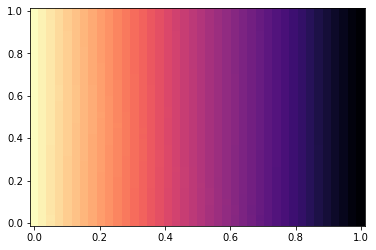

In [113]:
%%time

V_0 = np.zeros((N,N))
for i in range(N):
    V_0[i,0] = 1
V_k, i = SOR(V_0,V_analytic, N, 1.9, 0.1)
plt.pcolormesh(xx,yy,V_k, cmap='magma', shading='auto')
print('Programmet kjørte' ,i, 'iterasjoner')

### Ekstraoppgave

<ul>
    
<li> Prøv å skru opp systemstørrelsen for de tre metodene og undersøk om forholdet mellom kjøretidene og anntall steg endrer seg.</li>
<li> Fungerer metodene for en vilkårlig prøveløsning (med riktige grensebetingelser)? Prøv å lag noen sjuke prøveløsninger og se om det fortsatt konvergerer mot riktig løsning. </li>
</ul>